In [45]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *

torch.backends.cudnn.benchmark = True

img_wh = (128, 128)

# dataset = dataset_dict['llff'] \
#           ('/home/ubuntu/data/nerf_example_data/my/silica4/', 'test_train', spheric_poses=True,
#            img_wh=img_wh)

dataset = dataset_dict['pyredner'] \
          ('/home/ktiwary/cv-graphics/datasets/volumetric/single_box_pyredner/scene_1/', 'val',
           img_wh=img_wh)

Loading PyRedner dataset /home/ktiwary/cv-graphics/datasets/volumetric/single_box_pyredner/scene_1/
Image Size set to:  (128, 128)
Dataset Shapes cam_rays: torch.Size([15, 16384, 8]), light_rays: torch.Size([15, 16384, 8])


In [46]:
!ls ./ckpts/test_1/

'epoch=0.ckpt'	 'epoch=12.ckpt'  'epoch=14.ckpt'
'epoch=11.ckpt'  'epoch=13.ckpt'  'epoch=15.ckpt'


In [47]:
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = './ckpts/test_1/epoch=15.ckpt'
# ckpt_path = 'ckpts/exp2/epoch=05.ckpt'

# ckpt_path = 'ckpts/fern/epoch=29.ckpt'
# ckpt_path = 'ckpts/silica3_3/epoch=29.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [48]:
models = [nerf_coarse, nerf_fine]
embeddings = [embedding_xyz, embedding_dir]

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32*4

@torch.no_grad()
def f(rays):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [49]:
sample = dataset[0]
rays = sample['cam_ray_bundle'].cuda()

t = time.time()
results = f(rays)
torch.cuda.synchronize()
print(time.time()-t)

0.825484037399292


PSNR 6.418272972106934


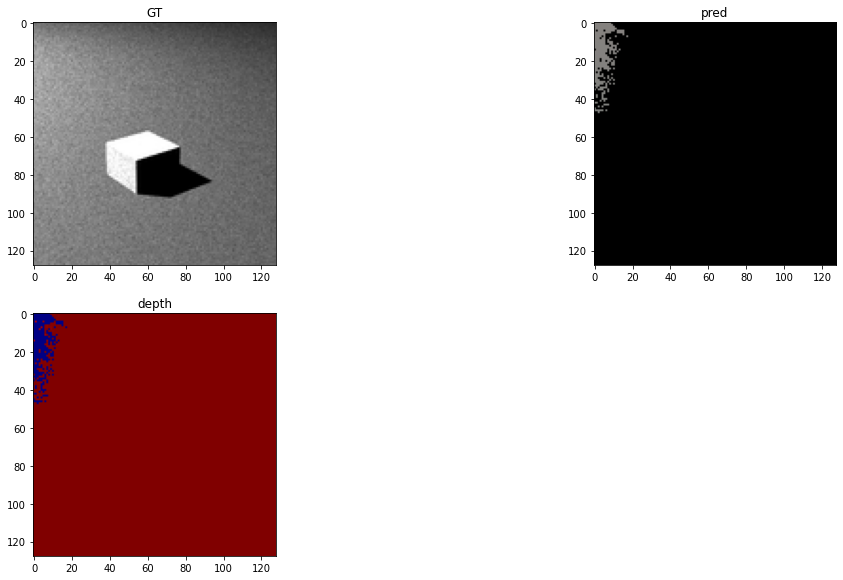

In [50]:
img_gt = sample['rgb'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

In [44]:
sample.keys()

dict_keys(['img_id', 'rgb', 'shadow_maps', 'cam_ray_bundle', 'light_ray_bundle', 'hw'])